<a href="https://colab.research.google.com/github/Adrita2211/ML_Project/blob/main/click-stream-data-analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import pandas as pd
import numpy as np
from collections import defaultdict
import matplotlib.pyplot as plt
import seaborn as sns
import ast

In [3]:
clickStreamData = pd.read_excel("/content/sample_data/click_stream_new.xlsx", engine='openpyxl')

In [4]:
df = pd.DataFrame(clickStreamData)

In [5]:
df.head()

,session_id,event_name,event_time,event_id,traffic_source,event_metadata
0,fb0abf9e-fd1a-44dd-b5c0-2834d5a4b81c,HOMEPAGE,2019-09-06T15:54:32.821085Z,9c4388c4-c95b-4678-b5ca-e9cbc0734109,MOBILE,NaN
1,fb0abf9e-fd1a-44dd-b5c0-2834d5a4b81c,SCROLL,2019-09-06T16:03:57.821085Z,4690e1f5-3f99-42d3-84a5-22c4c4d8500a,MOBILE,NaN
2,7d440441-e67a-4d36-b324-80ffd636d166,HOMEPAGE,2019-09-01T12:05:10.322763Z,88aeaeb5-ec98-4859-852c-8abb483faf31,MOBILE,NaN
3,7d440441-e67a-4d36-b324-80ffd636d166,ADD_TO_CART,2019-09-01T12:06:33.322763Z,934e306e-ecc6-472f-9ccb-12c8536910a2,MOBILE,"{'product_id': 15315, 'quantity': 4, 'item_pri..."
4,7d440441-e67a-4d36-b324-80ffd636d166,BOOKING,2019-09-01T12:15:29.425431Z,9f4767a1-40fa-4c9c-9524-dfad18634d56,MOBILE,{'payment_status': 'Success'}


In [6]:
df['event_time'] = pd.to_datetime(df['event_time'])

In [7]:
## Prepare the Data
print("Step 1: Preparing the data...")
# Sort by session and time to get correct event sequence
df = df.sort_values(['session_id', 'event_time'])


Step 1: Preparing the data...


In [8]:
##  Find All Transitions
print("\nStep 2: Finding all transitions between events...")
transitions = []


Step 2: Finding all transitions between events...


In [9]:
for session, group in df.groupby('session_id'):
    events = group['event_name'].tolist()
    # Create pairs of consecutive events
    for i in range(len(events)-1):
        transitions.append((events[i], events[i+1]))

print(f"Found {len(transitions)} transition pairs")
print("Sample transitions:", transitions[:10])

Found 984029 transition pairs
Sample transitions: [('HOMEPAGE', 'ADD_TO_CART'), ('ADD_TO_CART', 'HOMEPAGE'), ('HOMEPAGE', 'CLICK'), ('CLICK', 'CLICK'), ('CLICK', 'ITEM_DETAIL'), ('ITEM_DETAIL', 'SCROLL'), ('SCROLL', 'BOOKING'), ('HOMEPAGE', 'SEARCH'), ('SEARCH', 'ADD_TO_CART'), ('ADD_TO_CART', 'SCROLL')]


In [10]:
## Transition Occurrences
print("\nStep 3: Counting how often each transition occurs...")
transition_counts = defaultdict(int)

for from_event, to_event in transitions:
    transition_counts[(from_event, to_event)] += 1



Step 3: Counting how often each transition occurs...


In [11]:
# Convert to DataFrame for easier viewing
counts_df = pd.DataFrame(list(transition_counts.items()),
                        columns=['Transition', 'Count'])
print("\nTransition counts:")
print(counts_df.sort_values('Count', ascending=False))


Transition counts:
                  Transition  Count
3             (CLICK, CLICK)  51079
0    (HOMEPAGE, ADD_TO_CART)  43120
2          (HOMEPAGE, CLICK)  37748
16           (SCROLL, CLICK)  34572
17           (CLICK, SCROLL)  34472
..                       ...    ...
64   (PROMO_PAGE, ADD_PROMO)   1761
52    (BOOKING, ITEM_DETAIL)   1630
72  (ADD_PROMO, ADD_TO_CART)   1244
75         (BOOKING, SEARCH)   1166
76     (BOOKING, PROMO_PAGE)    713

[77 rows x 2 columns]


In [12]:
## Step 4: Calculate Transition Probabilities
print("\nStep 4: Calculating transition probabilities...")

# Get all unique events
all_events = df['event_name'].unique()


Step 4: Calculating transition probabilities...


In [13]:
# Create matrix of zeros (events x events)
prob_matrix = pd.DataFrame(0, index=all_events, columns=all_events)

# Fill in the counts
for (from_event, to_event), count in transition_counts.items():
    prob_matrix.loc[from_event, to_event] = count

In [14]:
# Convert counts to probabilities
prob_matrix = prob_matrix.div(prob_matrix.sum(axis=1), axis=0)
prob_matrix = prob_matrix.fillna(0)  # Replace NaN with 0 where no transitions

print("\nTransition Probability Matrix:")
print(prob_matrix)


Transition Probability Matrix:
             HOMEPAGE  ADD_TO_CART     CLICK  ITEM_DETAIL    SCROLL   BOOKING  \
HOMEPAGE     0.152739     0.219676  0.192308     0.103011  0.135932  0.039182   
ADD_TO_CART  0.101473     0.163060  0.220234     0.108894  0.140511  0.065898   
CLICK        0.131517     0.090040  0.234878     0.112636  0.158514  0.074038   
ITEM_DETAIL  0.144142     0.091044  0.229124     0.116270  0.158840  0.071955   
SCROLL       0.139187     0.084993  0.233205     0.114694  0.160482  0.070632   
BOOKING      0.330852     0.000000  0.191938     0.136322  0.183742  0.000000   
SEARCH       0.135168     0.083667  0.235224     0.114188  0.160721  0.073403   
ADD_PROMO    0.125103     0.044580  0.251675     0.107723  0.169504  0.108224   
PROMO_PAGE   0.142991     0.088881  0.230713     0.109846  0.159604  0.070275   

               SEARCH  ADD_PROMO  PROMO_PAGE  
HOMEPAGE     0.095578   0.015813    0.045759  
ADD_TO_CART  0.102969   0.049257    0.047703  
CLICK        0.1


Step 5: Creating visualization...


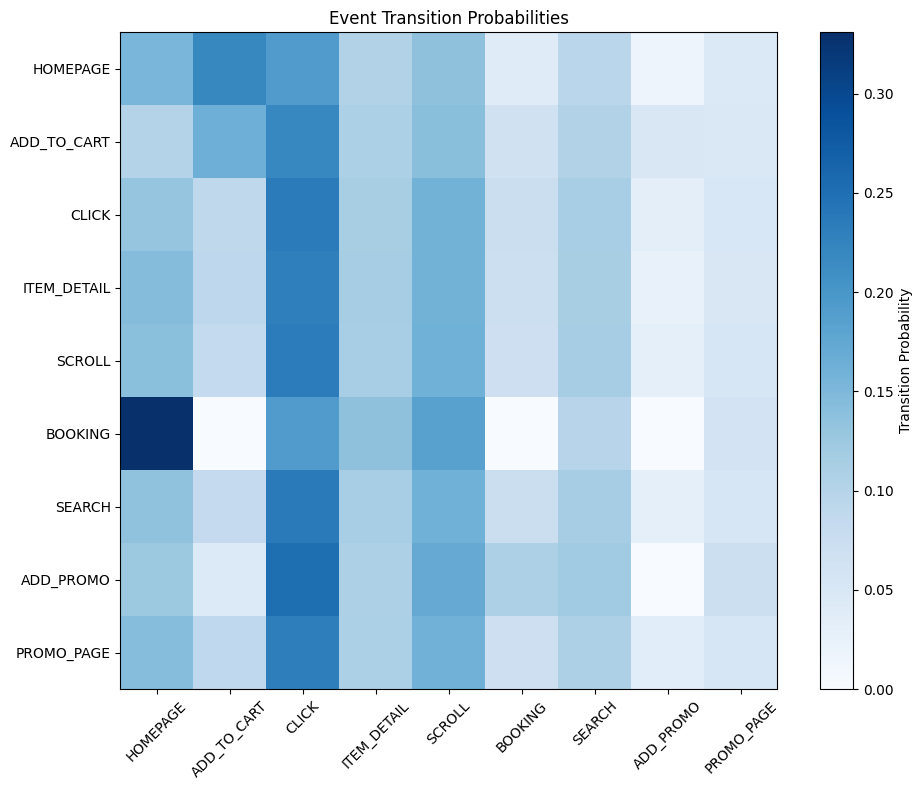

In [15]:

## Step 5: Visualize the Results
print("\nStep 5: Creating visualization...")
plt.figure(figsize=(10, 8))
plt.imshow(prob_matrix, cmap='Blues')
plt.colorbar(label='Transition Probability')
plt.xticks(range(len(all_events)), all_events, rotation=45)
plt.yticks(range(len(all_events)), all_events)
plt.title('Event Transition Probabilities')
plt.tight_layout()
plt.show()

In [16]:

## Analyze Key Paths
print("\nStep 6: Analyzing important paths...")

# Find all paths to booking
booking_paths = []
for session, group in df.groupby('session_id'):
    events = group['event_name'].tolist()
    if 'BOOKING' in events:
        # Get the path that led to booking
        path = events[:events.index('BOOKING')+1]
        booking_paths.append(path)

print("\nPaths that led to BOOKING:")
for path in booking_paths:
    print(" → ".join(path))

## Step 7: Calculate Conversion Rate
print("\nStep 7: Calculating conversion rate...")
total_sessions = df['session_id'].nunique()
booking_sessions = df[df['event_name'] == 'BOOKING']['session_id'].nunique()
conversion_rate = (booking_sessions / total_sessions) * 100

print(f"\nConversion Rate to Booking: {conversion_rate:.1f}%")

## Step 8: Save Results (Optional)
print("\nStep 8: Saving results...")
prob_matrix.to_csv('transition_probabilities.csv')
print("Saved transition probabilities to 'transition_probabilities.csv'")


Streaming output truncated to the last 5000 lines.
HOMEPAGE → ADD_TO_CART → SCROLL → HOMEPAGE → ADD_PROMO → CLICK → ITEM_DETAIL → SEARCH → CLICK → SEARCH → CLICK → CLICK → BOOKING
HOMEPAGE → ADD_TO_CART → ADD_TO_CART → ADD_TO_CART → ITEM_DETAIL → HOMEPAGE → HOMEPAGE → ADD_TO_CART → ITEM_DETAIL → ITEM_DETAIL → ADD_TO_CART → SCROLL → CLICK → ADD_TO_CART → HOMEPAGE → ITEM_DETAIL → BOOKING
HOMEPAGE → SCROLL → ADD_TO_CART → CLICK → ADD_TO_CART → CLICK → ADD_TO_CART → SCROLL → ADD_TO_CART → CLICK → SCROLL → BOOKING
HOMEPAGE → ADD_TO_CART → CLICK → SEARCH → CLICK → CLICK → ITEM_DETAIL → CLICK → SEARCH → SCROLL → SEARCH → SCROLL → BOOKING
HOMEPAGE → HOMEPAGE → ADD_TO_CART → CLICK → ADD_TO_CART → CLICK → ADD_PROMO → CLICK → CLICK → SCROLL → SCROLL → SEARCH → SCROLL → ITEM_DETAIL → ITEM_DETAIL → HOMEPAGE → ITEM_DETAIL → CLICK → ITEM_DETAIL → ITEM_DETAIL → HOMEPAGE → SEARCH → SEARCH → HOMEPAGE → SEARCH → SCROLL → BOOKING
HOMEPAGE → SCROLL → ADD_TO_CART → HOMEPAGE → ADD_PROMO → SEARCH → PROMO_PAGE